# Can a computer learn if we're going to detect gravitational waves?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix

In [2]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
f.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

#### SNR threshold = 12

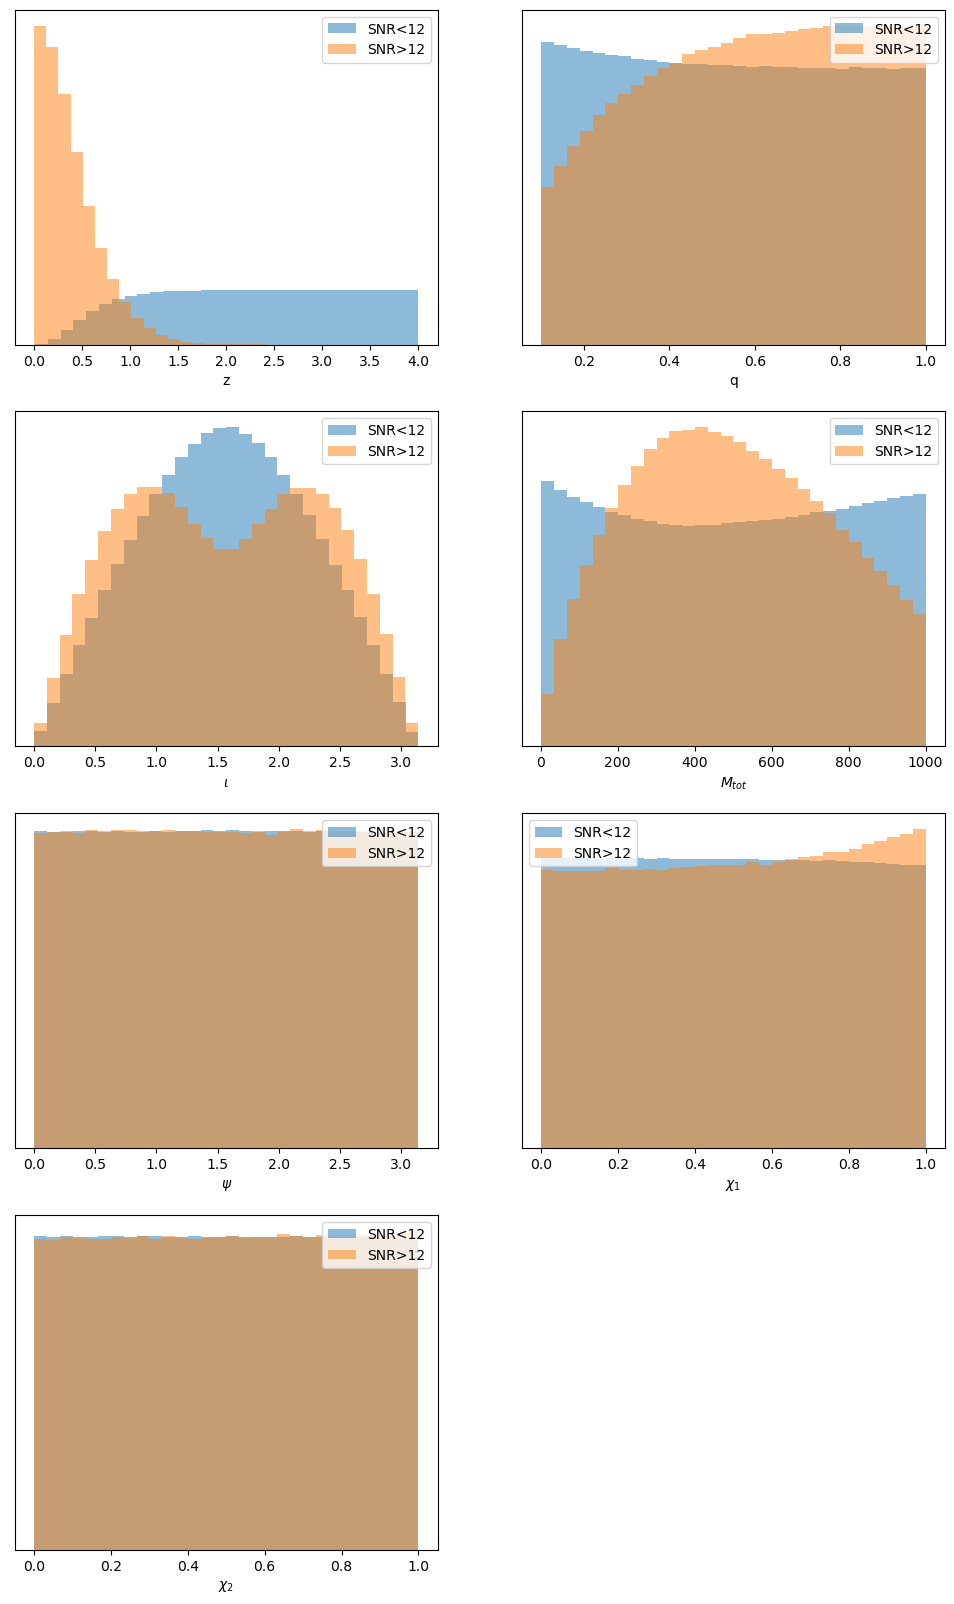

In [3]:
fig = plt.figure(figsize=(12,20))
density = True

ax1 = fig.add_subplot(421)
ax1.hist(f['z'][f['det'][:]==0], 30, alpha=0.5, density=density, label='SNR<12')
ax1.hist(f['z'][f['det'][:]==1], 30, alpha=0.5, density=density, label='SNR>12')
ax1.set_xlabel('z')
ax1.set_yticks([])
plt.legend()

ax2 = fig.add_subplot(422)
ax2.hist(f['q'][f['det'][:]==0], 30, alpha=0.5, density=density, label='SNR<12')
ax2.hist(f['q'][f['det'][:]==1], 30, alpha=0.5, density=density, label='SNR>12')
ax2.set_xlabel('q')
ax2.set_yticks([])
plt.legend()

ax3 = fig.add_subplot(423)
ax3.hist(f['iota'][f['det'][:]==0], 30, alpha=0.5, density=density, label='SNR<12')
ax3.hist(f['iota'][f['det'][:]==1], 30, alpha=0.5, density=density, label='SNR>12')
ax3.set_xlabel('$\iota$')
ax3.set_yticks([])
plt.legend()

ax4 = fig.add_subplot(424)
ax4.hist(f['mtot'][f['det'][:]==0], 30, alpha=0.5, density=density, label='SNR<12')
ax4.hist(f['mtot'][f['det'][:]==1], 30, alpha=0.5, density=density, label='SNR>12')
ax4.set_xlabel('$M_{tot}$')
ax4.set_yticks([])
plt.legend()

ax5 = fig.add_subplot(425)
ax5.hist(f['psi'][f['det'][:]==0], 30, alpha=0.5, density=density, label='SNR<12')
ax5.hist(f['psi'][f['det'][:]==1], 30, alpha=0.5, density=density, label='SNR>12')
ax5.set_xlabel('$\psi$')
ax5.set_yticks([])
plt.legend()

ax6 = fig.add_subplot(426)
ax6.hist((f['chi1x'][f['det'][:]==0]**2+f['chi1y'][f['det'][:]==0]**2+f['chi1z'][f['det'][:]==0]**2)**0.5, 30, alpha=0.5, density=density, label='SNR<12')
ax6.hist((f['chi1x'][f['det'][:]==1]**2+f['chi1y'][f['det'][:]==1]**2+f['chi1z'][f['det'][:]==1]**2)**0.5, 30, alpha=0.5, density=density, label='SNR>12')
ax6.set_xlabel('$\chi_1$')
ax6.set_yticks([])
plt.legend()

ax7 = fig.add_subplot(427)
ax7.hist((f['chi2x'][f['det'][:]==0]**2+f['chi2y'][f['det'][:]==0]**2+f['chi2z'][f['det'][:]==0]**2)**0.5, 30, alpha=0.5, density=density, label='SNR<12')
ax7.hist((f['chi2x'][f['det'][:]==1]**2+f['chi2y'][f['det'][:]==1]**2+f['chi2z'][f['det'][:]==1]**2)**0.5, 30, alpha=0.5, density=density, label='SNR>12')
ax7.set_xlabel('$\chi_2$')
ax7.set_yticks([])
plt.legend()

plt.show()

From the plots above we can see that the distribution of the binaries is uniform in $\psi$ and $\chi_2$, the polarization angle and the module of the secondary object's spin. There is no dependence of the observability on these two features, while we notice preferred ranges for the others. Therefore, we exclude $\psi$ and $\chi_2$ from our analysis.

#### Downsampling

In [4]:
N = 1000       # take one data every N    -->   final_lenght = 20'000'000 / N

z = f['z'][::N]
q = f['q'][::N]
mtot = f['mtot'][::N]
iota = f['iota'][::N]
chi1 = ( f['chi1x'][::N]**2 + f['chi1y'][::N]**2 + f['chi1z'][::N]**2 )**0.5

det = f['det'][::N]

z.shape

(20000,)

#### Split into training and validation

In [5]:
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

X = np.array([z, q, mtot, iota, chi1]).T
y = np.array(det)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)
print(X_train.shape, X_test.shape)

(15000, 5) (5000, 5)


### Decision tree: entropy criterion

completeness [[0.80911681 0.75498575 0.83333333 0.83333333 0.83333333]
 [0.71652422 0.77777778 0.81623932 0.81766382 0.81766382]]
contamination [[0.2386059  0.17829457 0.20081967 0.20081967 0.20081967]
 [0.17944535 0.20754717 0.17790531 0.17052023 0.16081871]]
Confusion Matrix 
 [[4188  110]
 [ 128  574]]
Efficiency =  0.9524


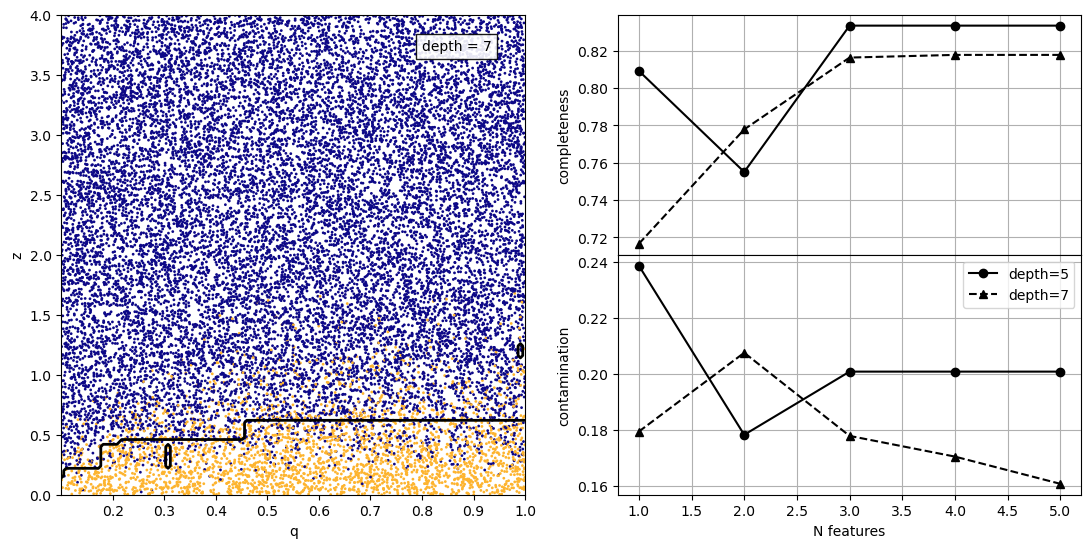

In [6]:
from sklearn.tree import DecisionTreeClassifier

N_tot = len(y)
N_train = len(y_train)
N_test = len(y_test)

#----------------------------------------------------------------------
# Fit Decision tree
Nfeatures = np.arange(1, X.shape[1] + 1)

classifiers = []
predictions = []
depths = [5,7]

for depth in depths:
    classifiers.append([])
    predictions.append([])
    for nc in Nfeatures:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth, criterion='entropy')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

CM = confusion_matrix(y_test, y_pred)
print("Confusion Matrix \n", CM)
print("Efficiency = ", np.sum(CM.diagonal())/len(y_test))

#------------------------------------------------------------
# compute the decision boundary

clf = classifiers[1][1]
xlim = (min(q), 1)
ylim = (0, 4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:],
                s=4, lw=0, cmap=plt.cm.plasma, alpha=1, zorder=2)
im.set_clim(0, 1.2)

ax.contour(xx, yy, Z, [0.5], colors='k', linewidths=2)

ax.set_xlabel('q')
ax.set_ylabel('z')

ax.text(0.8, 3.7, "depth = %i" % depths[1], bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))

# plot completeness vs Nfeatures
ax = fig.add_subplot(222)
ax.plot(Nfeatures, completeness[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Nfeatures, completeness[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.set_ylabel('completeness')
ax.grid(True)

# plot contamination vs Nfeatures
ax = fig.add_subplot(224)
ax.plot(Nfeatures, contamination[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Nfeatures, contamination[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.legend()
ax.set_xlabel('N features')
ax.set_ylabel('contamination')
ax.grid(True)

plt.show()

### Decision tree: Gini criterion

completeness [[0.76780627 0.76353276 0.79344729 0.83475783 0.83475783]
 [0.73361823 0.8019943  0.82336182 0.85470085 0.85897436]]
contamination [[0.20967742 0.2        0.14701378 0.18723994 0.18723994]
 [0.1953125  0.22982216 0.18591549 0.18588874 0.19385027]]
Confusion Matrix 
 [[4153  145]
 [  99  603]]
Efficiency =  0.9512


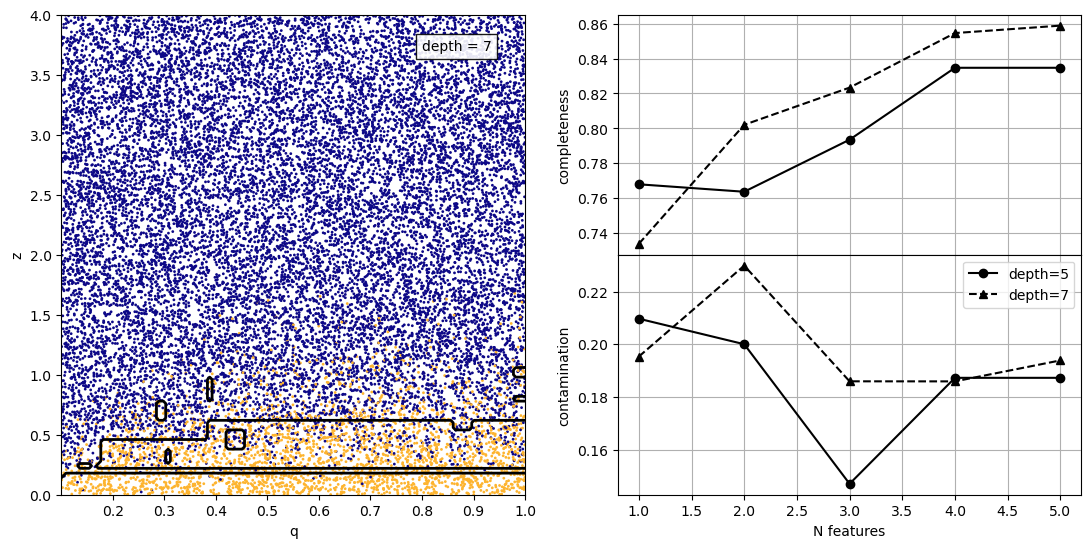

In [7]:
classifiers = []
predictions = []

for depth in depths:
    classifiers.append([])
    predictions.append([])
    for nc in Nfeatures:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth, criterion='gini')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

CM = confusion_matrix(y_test, y_pred)
print("Confusion Matrix \n", CM)
print("Efficiency = ", np.sum(CM.diagonal())/len(y_test))

#------------------------------------------------------------
# compute the decision boundary

clf = classifiers[1][1]
xlim = (min(q), 1)
ylim = (0, 4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:],
                s=4, lw=0, cmap=plt.cm.plasma, alpha=1, zorder=2)
im.set_clim(0, 1.2)

ax.contour(xx, yy, Z, [0.5], colors='k', linewidths=2)

ax.set_xlabel('q')
ax.set_ylabel('z')

ax.text(0.8, 3.7, "depth = %i" % depths[1], bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))

# plot completeness vs Nfeatures
ax = fig.add_subplot(222)
ax.plot(Nfeatures, completeness[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Nfeatures, completeness[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.set_ylabel('completeness')
ax.grid(True)

# plot contamination vs Nfeatures
ax = fig.add_subplot(224)
ax.plot(Nfeatures, contamination[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Nfeatures, contamination[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.legend()
ax.set_xlabel('N features')
ax.set_ylabel('contamination')
ax.grid(True)

plt.show()

### Optimize the depth: 2 features (z, q)

In [15]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=40, criterion='entropy')
drange = np.arange(1,21)  

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) 
grid.fit(X[:,:2], y)

best2 = grid.best_params_['max_depth']
print("best parameter choice:", best2)

best parameter choice: 6


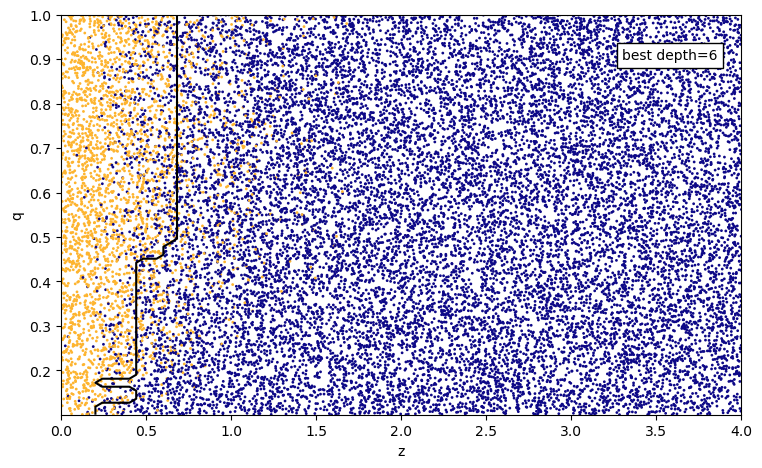

In [16]:
dt = DecisionTreeClassifier(random_state=0, max_depth=best2, criterion='entropy')
dt.fit(X_train[:,:2], y_train)

xlim = (0, 4)
ylim = (min(q), 1)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 51),
                     np.linspace(ylim[0], ylim[1], 51))
xystack = np.vstack([xx.ravel(),yy.ravel()])               
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y[:],
                s=4, lw=0, cmap=plt.cm.plasma, alpha=1, zorder=2)
im.set_clim(0, 1.2)

ax.contour(xx, yy, Z, [0.5], colors='k')

plt.text(3.3, 0.9, "best depth="+str(best2), bbox=dict(facecolor='white', edgecolor='black'))

plt.xlabel('z')
plt.ylabel('q')
plt.show()

The decision boundary with the optimization of the depth reduces the overfitting. 

### Optimize the depth: all features

In [17]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0, criterion='entropy')
drange = np.arange(1,21)  

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) 
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 8


The best depth value differs from the one estimated using only two features.

completeness  [0.71509972 0.78774929 0.8019943  0.87179487 0.86894587]
contamination [0.18506494 0.22657343 0.18523878 0.2        0.20469361]
Confusion Matrix 
 [[4141  157]
 [  92  610]]
Efficiency =  0.9502


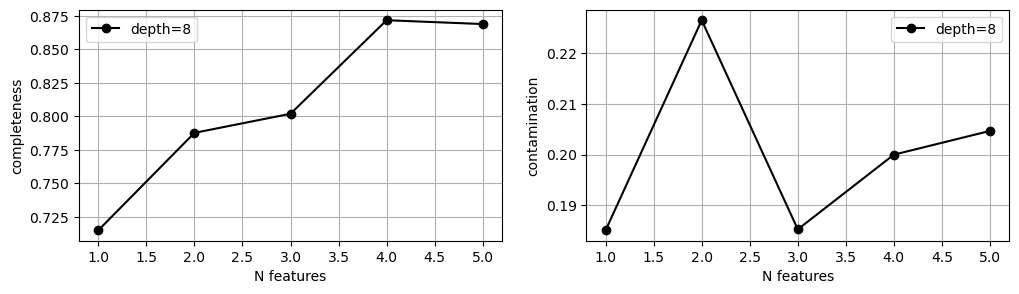

In [18]:
classifiers = []
predictions = []

for nc in Nfeatures:
    dtc = DecisionTreeClassifier(random_state=0, max_depth=best, criterion='entropy')
    dtc.fit(X_train[:, :nc], y_train)
    y_pred = dtc.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness ", completeness)
print("contamination", contamination)

CM = confusion_matrix(y_test, y_pred)
print("Confusion Matrix \n", CM)
print("Efficiency = ", np.sum(CM.diagonal())/len(y_test))

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(12, 3))

# plot completeness vs Nfeatures
ax = fig.add_subplot(121)
ax.plot(Nfeatures, completeness, 'o-k', ms=6, label="depth=%i" % best)
plt.legend()
ax.set_xlabel('N features')
ax.set_ylabel('completeness')
ax.grid(True)

# plot contamination vs Nfeatures
ax = fig.add_subplot(122)
ax.plot(Nfeatures, contamination, 'o-k', ms=6, label="depth=%i" % best)
ax.legend()
ax.set_xlabel('N features')
ax.set_ylabel('contamination')
ax.grid(True)

plt.show()

### Regressor on SNR

In [19]:
snr = f['snr'][::N]
snr.shape

(20000,)

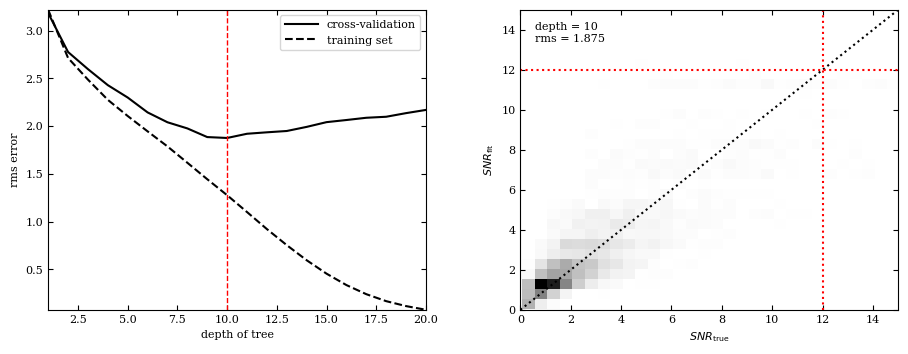

In [25]:
from sklearn.tree import DecisionTreeRegressor

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------

(X_train, X_test), (y_train, y_test) = split_samples(X[snr<50], snr[snr<50], [0.75, 0.25], random_state=25)

#------------------------------------------------------------
# Compute the cross-validation scores for several tree depths
depth = np.arange(1, 21)
rms_test = np.zeros(len(depth))
rms_train = np.zeros(len(depth))
i_best = 0
#y_fit_best = None

for i, d in enumerate(depth):
    clf = DecisionTreeRegressor(max_depth=d, random_state=0)
    clf.fit(X_train, y_train)

    y_fit_train = clf.predict(X_train)
    y_fit = clf.predict(X_test)
    rms_train[i] = np.mean(np.sqrt((y_fit_train - y_train) ** 2))
    rms_test[i] = np.mean(np.sqrt((y_fit - y_test) ** 2))

    if rms_test[i] <= rms_test[i_best]:
        i_best = i
        y_fit_best = y_fit

best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# first panel: cross-validation
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.axvline(depth[i_best], color='r', lw=1, ls='dashed')
ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')
ax.legend(loc=1)

# second panel: best-fit results
ax = fig.add_subplot(122)
edges = np.linspace(y_test.min(), y_test.max(), 101)
H, ys_bins, yp_bins = np.histogram2d(y_test, y_fit_best, bins=edges)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[ys_bins[0], ys_bins[-1], ys_bins[0], ys_bins[-1]],
           cmap=plt.cm.binary)

ax.plot([-0, 50], [0, 50], ':k')
ax.text(0.04, 0.96, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$SNR_{\rm true}$')
ax.set_ylabel(r'$SNR_{\rm fit}$')

ax.set_xlim(0, 15)
ax.set_ylim(0, 15)

plt.axvline(x=12, color='red', linestyle=':')
plt.axhline(y=12, color='red', linestyle=':')

plt.show()

In [22]:
y_pred = (y_fit_best <= 12).astype(int)
y_real = (y_test <= 12).astype(int)

CM = confusion_matrix(y_real, y_pred)
print("Confusion Matrix \n", CM)
print("Efficiency = ", np.sum(CM.diagonal())/len(y_pred))

Confusion Matrix 
 [[ 396  127]
 [ 102 4162]]
Efficiency =  0.9521621057029455
